# Банки — анализ оттока клиентов


## Подготовительный этап

### Описание проекта и целей исследования

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

**Цель исследования**
- Проанализировать клиентов регионального банка и выделить сегменты клиентов, которые склонны уходить из банка.
- Подготовить рекомендации по уменьшению оттока для каждого из выделенных сегментов

### Импорт библиотек

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
from random import randrange

import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

import os

from scipy import stats as st
import math as mth

from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell

import warnings
warnings.filterwarnings("ignore")

#список всех цветов из matplotlib
colors_list = list(colors._colors_full_map.values())

#вывод всех столбцов
pd.set_option('display.max_columns', None)

#формат отображения
pd.set_option('float_format', '{:f}'.format)
pd.options.display.float_format = '{: .2f}'.format

#отображение всех выводов из одной ячейки
InteractiveShell.ast_node_interactivity = "all"

### Загрузка датасета

In [2]:
# чтение файла bank_scrooge.csv с данными и сохранение его в переменную 
path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F" 
data = pd.read_csv(path)

## Изучение общей информации и предобработка

### Общая информация о датасете

In [3]:
data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.00,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1
1,146556,861.00,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0
2,120722,892.00,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
3,225363,866.00,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1
4,157978,730.00,Ярославль,М,34,5,174.00,1,1,0,67353.16,1


In [4]:
shape0 = data.shape[0]
print(f'В логе всего {shape0} событий')

В логе всего 10000 событий


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            10000 non-null  int64  
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 937.6+ KB


- Датасет состоит из 1000 строк и 12 колонок
- Пропуски только в колонке с балансом
- Переименую колонки, чтобы привести их названия к общему виду

### Переименование колонок

In [6]:
#Приведем названия колонок к общему виду
data = data.rename(columns = {'USERID': 'user_id', 'EST_SALARY' : 'est_salary'})

### Изменение типов данных

- В колонках с активностью клиента, наличием кредитной карты и информацией, ушел ли клиент изменю тип данных на булевый

In [7]:
for col in ['last_activity', 'credit_card', 'churn']:
    data[col]  = data[col].astype('bool')   

Проверим, что типы изменены

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            10000 non-null  int64  
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  bool   
 9   last_activity  10000 non-null  bool   
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  bool   
dtypes: bool(3), float64(3), int64(4), object(2)
memory usage: 732.5+ KB


### Пропуски, причины их возникновения, способ заполнения

In [9]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('Blues')

,0
user_id,0.000000
score,0.000000
city,0.000000
gender,0.000000
age,0.000000
equity,0.000000
balance,23.000000
products,0.000000
credit_card,0.000000
last_activity,0.000000


В колонке balance 23% пропусков. Выделю записи с пропусками в отдельный датасет, проверю, есть ли взаимосвязи с другими данными, чем можно объяснить причину пропусков и возможно ли их заполнить.

In [10]:
balance_nan = data.query('balance.isnull()')

In [11]:
#выделю колонки с разными типами в отдельные переменные
int_col = data.loc[:, data.columns != 'user_id'].select_dtypes(include=['int64', 'float64']).columns
bool_col = data.select_dtypes(include=['bool']).columns
obj_col = data.select_dtypes(include=['object']).columns

**Поиск взаимосвязей между данными в числовых колонках и пропусками в колонке balance**

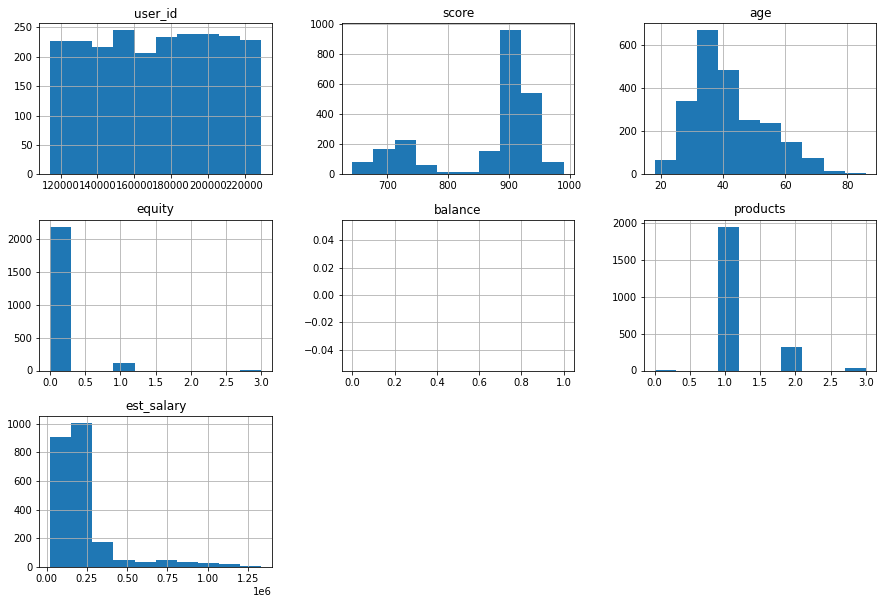

In [12]:
balance_nan.hist(figsize=(15, 10));

- Большая часть строк с пустым балансом у клиентов с одним продуктом и с самой низкой оценкой собственных средств (0 баллов).

**Поиск взаимосвязей между данными в текстовых колонках и пропусками в колонке balance**

In [13]:
for col in obj_col:
    print ('Количество значений в колонке', col)
    balance_nan[col].value_counts()

Количество значений в колонке city


Ярославль    1478
Рыбинск       578
Ростов        239
Name: city, dtype: int64

Количество значений в колонке gender


М    1283
Ж    1012
Name: gender, dtype: int64

- Распределение по городам и по полу не позволяет выявить взаимосвязь с  пропусками

**Поиск взаимосвязей между данными в колонках c булевым типом и пропусками в колонке balance**

In [14]:
for col in bool_col:
    print ('% значений в колонке', col, round(balance_nan[col].mean()*100,1))
    

% значений в колонке credit_card 81.6
% значений в колонке last_activity 54.9
% значений в колонке churn 0.6


- Среди клиентов с незаполненым балансом у 81,6% есть кредитные карты
- Почти все клиенты (более 99%) являются действующими

Проверю, какой % от незаполненных строк составляют клиенты, у которых есть кредитная карта, открыт всего 1 продукт и оценка собственности 0

In [15]:
(round (balance_nan.query('products == 1 and credit_card==1 and equity == 0').shape[0] /
 balance_nan.shape[0] *100, 2)
)

66.01

**Вывод:**
- 66% от незаполненных строк составляют клиенты, у которых есть кредитная карта, открыт всего 1 продукт и оценка собственности 0, скорее всего пропуски означают минусовый остаток на счету. 
- Причину остальных пропусков определить не удалось

**Заменить чем-то пропуски мы не можем, удалять также не буду, т.к 23% - это большая доля всего датасета. Оставлю как есть. Также необходимо обсудить с менеджером и сотрудниками, отвечающими за выгрузку, проблему с пропусками**

### Дубликаты явные и неявные

In [16]:
#проверка на полные дубликаты
data.duplicated().sum()

1

Обнаружен всего 1 полный дубликат, удалю его

In [17]:
data.drop_duplicates(inplace=True)

Проверю на дубликаты в user_id

In [18]:
data.user_id.duplicated().sum()

72

Удалю все строки с найденными user_id, т.к какие из них верные, а какие задублировались, определить не получится

In [19]:
data.drop_duplicates(subset= ['user_id'], keep=False, inplace=True)

print ('Дубликаты в user_id после удаления =', data.user_id.duplicated().sum())

Дубликаты в user_id после удаления = 0


In [20]:
#количество оставшихся после удаления данных, %
print (f'% оставшихся после удаления данных {round((data.shape[0]/shape0)*100, 2)}')

% оставшихся после удаления данных 98.55


### Проверка выбросов и адекватность значений

Посмотрим на описательную статистику по колонкам.

In [21]:
data.describe(include=[np.number, object])

,user_id,score,city,gender,age,equity,balance,products,est_salary
count,9855.00,9855.00,9855,9855,9855.00,9855.00,7608.00,9855.00,9855.00
unique,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Ярославль,М,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,5816,4930,NaN,NaN,NaN,NaN,NaN
mean,171659.30,848.51,NaN,NaN,42.87,2.63,823861.60,1.87,147595.67
std,33684.01,65.39,NaN,NaN,12.14,1.98,1982673.54,0.80,139005.82
min,94561.00,642.00,NaN,NaN,18.00,0.00,0.00,0.00,2546.30
25%,142585.50,802.00,NaN,NaN,34.00,0.00,294539.55,1.00,75082.76
50%,172466.00,852.00,NaN,NaN,40.00,3.00,522629.74,2.00,119460.10
75%,200976.00,899.00,NaN,NaN,51.00,4.00,975494.15,2.00,174495.66


Явно неадекватных значений в колонках нет, однако необходимо посмотреть диаграммы размаха и подробнее изучить выбросы:
- скоринг балл от 642 до 1000, 
- возвраст от 18 до 86 лет,
- баланс от 0 до 119 млн, 
- количество продуктов от 0 до 5, 
- заработная плата 2,5 тыс до 1,4 млнб
- 2 пола и 3 города
- оценка стоимости имущества от 0 до 9 баллов

**Посмотрим распределение данных в текстовых колонках:**

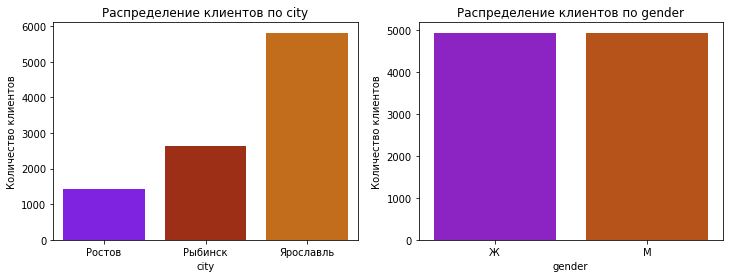

In [22]:
plt.figure(figsize=(12, 4))
for i, col in enumerate(obj_col.to_list()):
    plt.subplot(len(obj_col)/2, 2, i + 1);
    sns.barplot(data=data.groupby(col).user_id.count().reset_index(), y='user_id', x=col,palette = 'gnuplot')
    plt.title(f'Распределение клиентов по {col}')
    plt.xlabel(col)
    plt.ylabel('Количество клиентов')
plt.show(); 

**Построю диаграммы размаха по числовым колонкам**

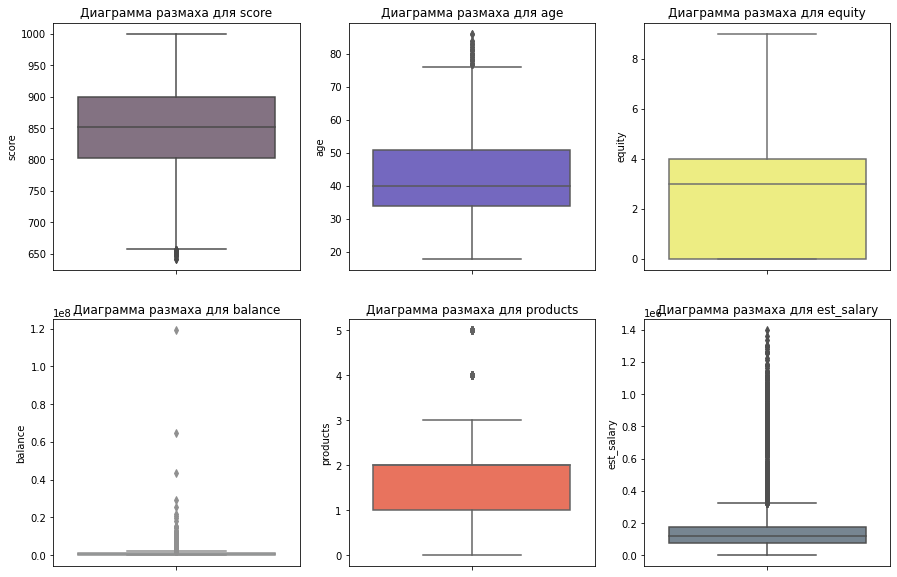

In [23]:
col_boxplot = ['score', 'age', 'equity', 'balance', 'products', 'est_salary']

plt.figure(figsize=(15, 10))
for i, col in enumerate(col_boxplot):
    plt.subplot(len(col_boxplot)/3, 3, i + 1);
    sns.boxplot(data=data, y=col, color=colors_list[randrange(len(colors_list))])
    plt.title(f'Диаграмма размаха для {col}')

plt.show(); 

 - Явные выбросы есть в балансе и зарплате, а также в возрасте клиентов, посмотрю их подробне, использую 3 стандартных отклонения от среднего
 - Количество продуктов, оценку собственности и баллы скоринга оставлю без изменений. Это больше категориальные значения, чем числовые. Только в количестве продуктов проверю 0, т.к если клиенты действующие, то у них не может быть 0 продуктов.

In [24]:
def removeOutliers(data, col):
    '''
    функция удаления выбросов по 3 стандартным отклонениям
    на вход принимает датасет и его колонку
    на выходе отфильтрованный датасет
    '''
    data_mean, data_std = data[col].mean(), data[col].std()
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off

    print(f'Минимальное значение для колонки {col}: {round(lower,2)}, Максимальное: {round(upper,2)}')
    global outlier_free_list
    global filtered_data
 
    outlier_free_list = [x for x in data[col] if (
        (x > lower) & (x < upper))]
    
    filtered_data = data.loc[data[col].isin(outlier_free_list) | data[col].isnull()]

In [27]:
def viewOutliers(data, col):
    '''
    функция просмотра значений  за пределами 3 стандартным отклонений
    на вход принимает датасет и его колонку
    на выходе датасет, состоящий из выбросов
    '''
    data_mean, data_std = data[col].mean(), data[col].std()
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off

    print(f'Значения за пределами 3 ст. отклонений для колонки {col}: меньше {round(lower,2)}, больше {round(upper,2)}')

    outlier_list = pd.Series ([x for x in data[col] if (
        (x <= lower) | (x >= upper))]).unique()
   
    #создаю отдельные датафреймы с выбросами по каждому признаку
    globals() [('outlier_data_'+str(col))]   = data.loc[data[col].isin(outlier_list)]
    print(f'Датафрейм с выбросами в колонке {col}:', ('outlier_data_'+str(col)))
    print ("Размеры датасета, состоящего из выбросов: ", eval('outlier_data_'+str(col)).shape)
    return eval('outlier_data_'+str(col)).sample(10)

**Значения в колонке возраст**

In [28]:
viewOutliers(data, 'age')

Значения за пределами 3 ст. отклонений для колонки age: меньше 6.44, больше 79.29
Датафрейм с выбросами в колонке age: outlier_data_age
Размеры датасета, состоящего из выбросов:  (22, 12)


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
9462,140275,898.00,Ярославль,Ж,80,2,1331131.18,2,True,True,107008.80,False
4703,219171,851.00,Ростов,Ж,80,3,411612.85,1,True,True,22280.91,False
1283,127231,796.00,Рыбинск,Ж,80,1,347590.32,2,True,False,27123.50,False
1987,219132,827.00,Рыбинск,Ж,82,3,275391.31,3,False,False,59205.90,False
4808,123464,846.00,Ярославль,Ж,80,1,182518.55,2,False,False,80769.31,False
9413,135210,921.00,Ярославль,Ж,86,0,NaN,1,False,True,36185.91,False
1621,151166,916.00,Рыбинск,Ж,83,0,NaN,1,True,True,55681.82,False
4387,117913,658.00,Рыбинск,Ж,81,0,NaN,1,True,True,105088.10,False
2795,214518,820.00,Ярославль,Ж,83,3,1137456.03,3,False,False,18037.97,False
219,161758,754.00,Ярославль,Ж,80,1,332616.82,3,False,True,114804.27,False


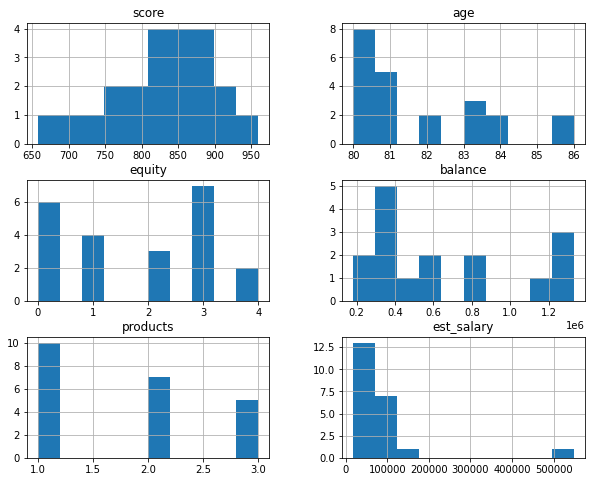

In [29]:
outlier_data_age.loc[:, outlier_data_age.columns != 'user_id'].hist(figsize = (10,8));

22 клиента старше 79 лет, все женщины, все работающие (есть зарплата). Хоть возраст и сильно отклоняется от среднего, но это не говорит от выбросах, поэтому удалять данные значения некорректно, оставлю их как есть

**Значения в колонке баланс**

In [30]:
viewOutliers(data, 'balance')

Значения за пределами 3 ст. отклонений для колонки balance: меньше -5124159.01, больше 6771882.2
Датафрейм с выбросами в колонке balance: outlier_data_balance
Размеры датасета, состоящего из выбросов:  (36, 12)


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2318,168713,837.00,Ярославль,М,62,5,12823205.04,1,True,True,21765.76,False
9753,122015,885.00,Ярославль,М,64,4,25727761.86,3,True,False,168746.90,False
3547,197903,957.00,Ярославль,М,66,4,8111590.39,4,True,True,410758.98,True
2776,155570,941.00,Ярославль,Ж,34,5,6916364.04,3,False,True,532898.14,True
7058,114087,878.00,Ярославль,М,61,5,12359917.91,2,False,True,56863.07,True
6318,163663,970.00,Ярославль,М,35,3,15004496.45,2,False,True,991012.77,True
7343,226500,969.00,Ярославль,М,32,3,12829755.02,4,True,True,544420.41,True
1846,114088,927.00,Ярославль,М,57,5,43277099.84,3,False,True,82619.00,False
7597,156149,900.00,Ярославль,М,62,5,119113552.01,2,True,True,138041.31,False
125,227092,1000.00,Ярославль,М,32,5,19757180.85,2,True,True,1024626.50,False


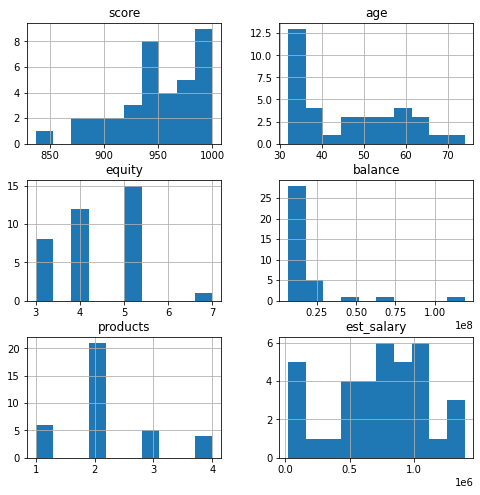

In [31]:
outlier_data_balance.loc[:, outlier_data_balance.columns != 'user_id'].hist(figsize = (8,8));

36 клиентов с балансом больше 6,8 млн. С высоким кредитным рейтингом, 30-35 лет, в основном с зарплатой от 500 тыс., со средней оценкой имущества (3-5). Т.е. все клиенты выглядят адекватными, никого из них нельзя назвать выбросами

**Выбросы в колонке зарплата**

In [32]:
viewOutliers(data, 'est_salary')

Значения за пределами 3 ст. отклонений для колонки est_salary: меньше -269421.79, больше 564613.13
Датафрейм с выбросами в колонке est_salary: outlier_data_est_salary
Размеры датасета, состоящего из выбросов:  (230, 12)


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
5160,174746,731.00,Ярославль,Ж,30,0,NaN,2,True,False,1296838.08,False
7087,167318,782.00,Рыбинск,Ж,37,0,NaN,1,True,True,690476.12,False
1238,197478,937.00,Ярославль,М,28,0,NaN,1,True,True,877996.35,False
3497,122304,948.00,Рыбинск,Ж,59,1,NaN,1,False,True,748295.46,False
9348,131699,738.00,Ярославль,М,48,0,NaN,2,True,False,759289.41,False
9060,136649,741.00,Ярославль,Ж,43,0,NaN,1,True,False,1027463.69,False
6720,179582,742.00,Ярославль,Ж,54,0,NaN,2,True,True,1108338.87,False
663,180853,949.00,Ярославль,М,45,0,NaN,1,True,False,1142166.48,False
6499,224019,936.00,Ярославль,М,31,5,2931344.63,2,False,True,1108269.91,True
4022,216692,935.00,Ярославль,Ж,45,0,NaN,1,True,False,753723.98,False


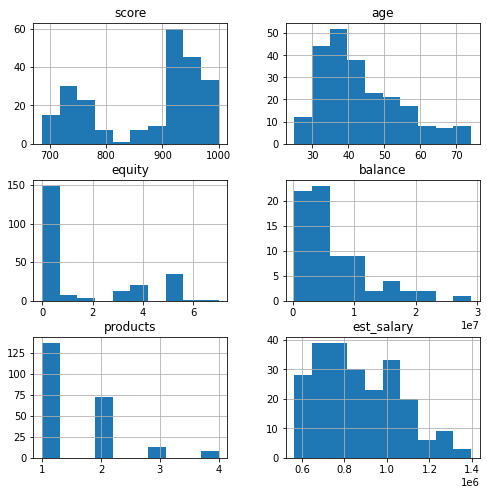

In [33]:
outlier_data_est_salary.loc[:, outlier_data_est_salary.columns != 'user_id'].hist(figsize = (8,8));

In [34]:
#% клиентов с кредитной картой
outlier_data_est_salary.credit_card.mean()

0.7739130434782608

230 клиентов с зарплатой выше 565 тыс. В основном это клиенты в возрасте 30-45 лет, с хорошей и отличной кредитной историей, с балансом до 500 тыс, с очень низкой оценкой имущества. Больше половины и них используют всего 1 продукт, у 77% есть кредитная карта. Портрет этих клиентов также вполне адекватный, выбросов не обнаружила

**Проверка данных с 0 продуктов**

In [35]:
data.query('products == 0')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8957,147837,962.00,Рыбинск,Ж,79,3,NaN,0,False,False,25063.96,True


Это всего 1 строка, клиент ушел. Удалю данные.

In [36]:
data = data.query('products != 0')

### Проверка данных после очистки

In [37]:
print('До обработки',shape0)
print('После обработки', data.shape[0])

#количество оставшихся после удаления данных, %
print (f'% удаленных данных {round((1-data.shape[0]/shape0)*100, 2)}')

До обработки 10000
После обработки 9854
% удаленных данных 1.46


## Анализ данных

### Категоризация столбцов score, balance, est_salary, age

#### Категоризация скоринга

При категоризации скоринг баллов возьму за основу систему ОКБ (Объединённое Кредитное Бюро), т.к у НБКИ максимальный балл 850, значит точно используется не система этого бюро, а у Эквифакса шкала 0-999, в то время как в датасете был балл 1000:
- выше 961 баллов — отличная кредитная история;
- 801-960 — хороший скоринговый балл;
- 721-800 — средний показатель, есть большой риск получить отказ;
- 641-720 — плохой кредитный скоринг;
- ниже 640 — безнадежный заемщик или банкрот.

In [38]:
bins = (-np.inf, 640, 720, 800, 960, np.inf)
labels = ['безнадежная', 'плохая', 'средняя', 'хорошая', 'отличная']
data['credit_history'] = pd.cut(data['score'], bins = bins, labels = labels)

#### Функция для категоризации баланса и зарплаты

In [39]:
def income_cat(data, col):
    '''
    уровень дохода определяем в зависимости от отклонения от медианы
    на вход датафрейм и колонка датафрейма, на выходе столбец с категориями
    '''
    global median
    median = data[col].median()
    bins = ( -np.inf, -0.001, 0.5*median, 1.5*median, 3*median, np.inf)
    labels = ['<0', 'low', 'medium', 'high', 'very high']
    return pd.cut(data[col], bins = bins, labels = labels)

#### Добавление колонки с категориями для баланса 

In [40]:
data['balance_cat'] = income_cat(data, 'balance')

#### Добавление колонки с категориями для зарплаты

In [41]:
data['est_salary_cat'] = income_cat(data, 'est_salary')

#### Добавление колонки с категориями для возраста

In [42]:
bins = (0, 17, 24, 44, 60, np.inf)
labels = ['0-17', '18-24', '25-44', '45-60', '60+']
data['age_cat'] = pd.cut(data['age'], bins = bins, labels = labels)

Таким образом мы получили 4 новых колонки с категориальными данными

In [43]:
data.sample(5)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,credit_history,balance_cat,est_salary_cat,age_cat
779,212862,707.00,Ярославль,Ж,28,0,NaN,1,True,True,170457.44,False,плохая,NaN,medium,25-44
2865,202586,884.00,Ярославль,Ж,35,4,1279201.99,4,True,True,152319.94,True,хорошая,high,medium,25-44
452,206118,797.00,Ярославль,М,62,1,162924.06,2,False,False,80896.57,True,средняя,low,medium,60+
8330,174741,827.00,Ярославль,М,32,5,492778.24,1,True,False,76166.91,True,хорошая,medium,medium,25-44
4429,115775,848.00,Рыбинск,М,45,2,712279.95,2,True,True,266799.85,False,хорошая,medium,high,45-60


### Гистограммы по всем числовым колонкам

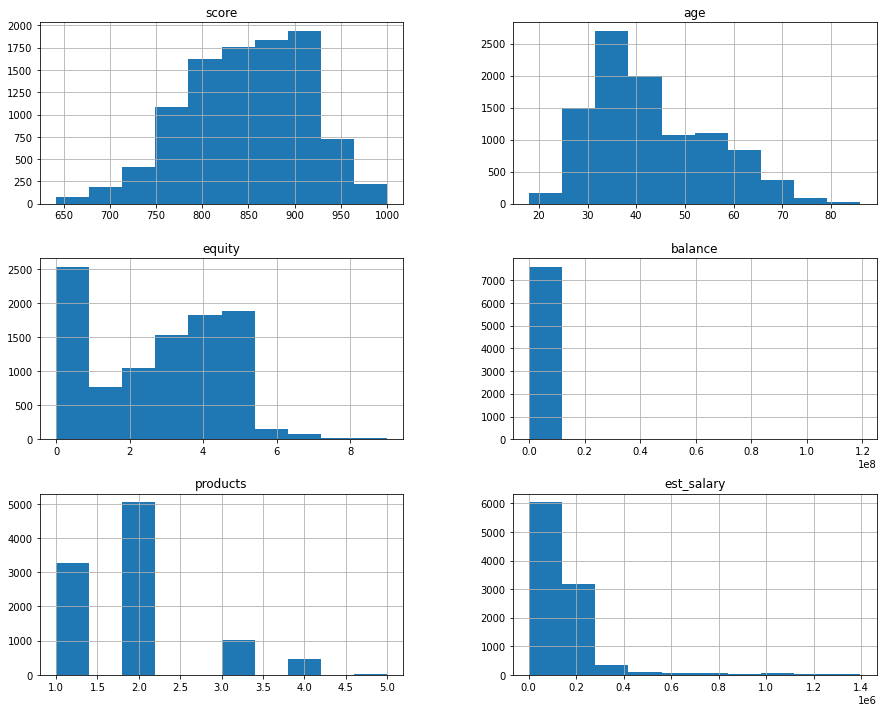

In [44]:
data.loc[:, data.columns != 'user_id'].hist(figsize=(15, 12));

**Комментарии:**
- Скоринг распределен нормально, в основном в диапазоне 790-920
- Возраст также распределен нормально, пик на 32-39 годах
- Оценка имущества имеет 2 пика, на нуле баллов, т.к имущества нет, и на 4-5, более высоко имущество почти не оценивают
- Баланс у половины клиентов меньше миллиона
- Зарплата у 60% клиентов до 150 тыс.
- У половины клиентов открыто 2 продукта, еще у 30% только 1 продукт

### Гистограммы по колонкам с булевыми значениями

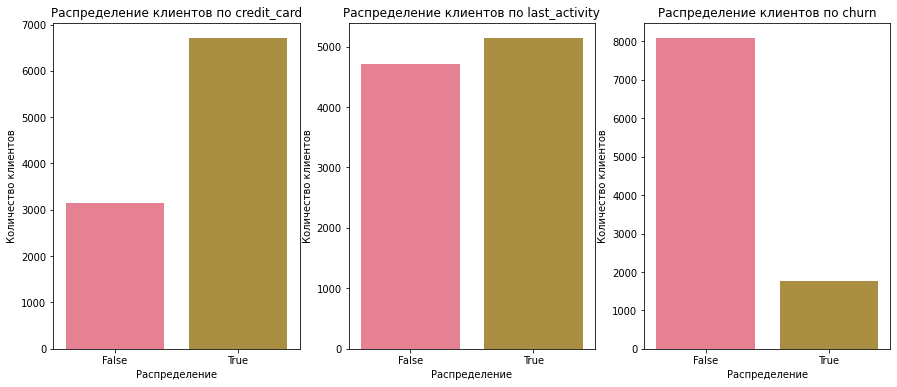

In [45]:
plt.figure(figsize=(15, 6))

for i, col in enumerate (bool_col):
    plt.subplot(1, 3, i+1);
    sns.set_palette("husl")
    
    df = data.groupby(col).user_id.count().reset_index()
    sns.barplot(x=df[col], y=df.user_id);
    
    plt.title(f'Распределение клиентов по {col}')
    plt.ylabel('Количество клиентов')
    plt.xlabel('Распределение');
plt.show;

**Комментарии:**
- Кредитная карта есть у 2/3 клиентов
- Активные и неактивные клиенты распределены примерно поровну
- Большая часть клиентов (около 80%) действующая

### Матрица рассеивания и корреляции

Определим, есть ли взаимосвязь между отдельными данными. Построим таблицу корреляции Пирсона по числовым данынм.

In [46]:
data[int_col].corr().style.background_gradient('Greens')

,score,age,equity,balance,products,est_salary
score,1.000000,-0.010698,0.063785,0.232036,-0.005827,0.162199
age,-0.010698,1.000000,0.032867,0.072536,0.034717,-0.043217
equity,0.063785,0.032867,1.000000,0.163061,0.430108,-0.173561
balance,0.232036,0.072536,0.163061,1.000000,0.072900,0.332970
products,-0.005827,0.034717,0.430108,0.072900,1.000000,-0.119760
est_salary,0.162199,-0.043217,-0.173561,0.332970,-0.119760,1.000000


Слабая положительная корреляция есть между 
- скорингом и балансом, 
- зарплатой и балансом,  
- а также стоимостью имущества и количеством открытых продуктов банка

Визуализируем связь, построив диаграмму рассеяния двух переменных

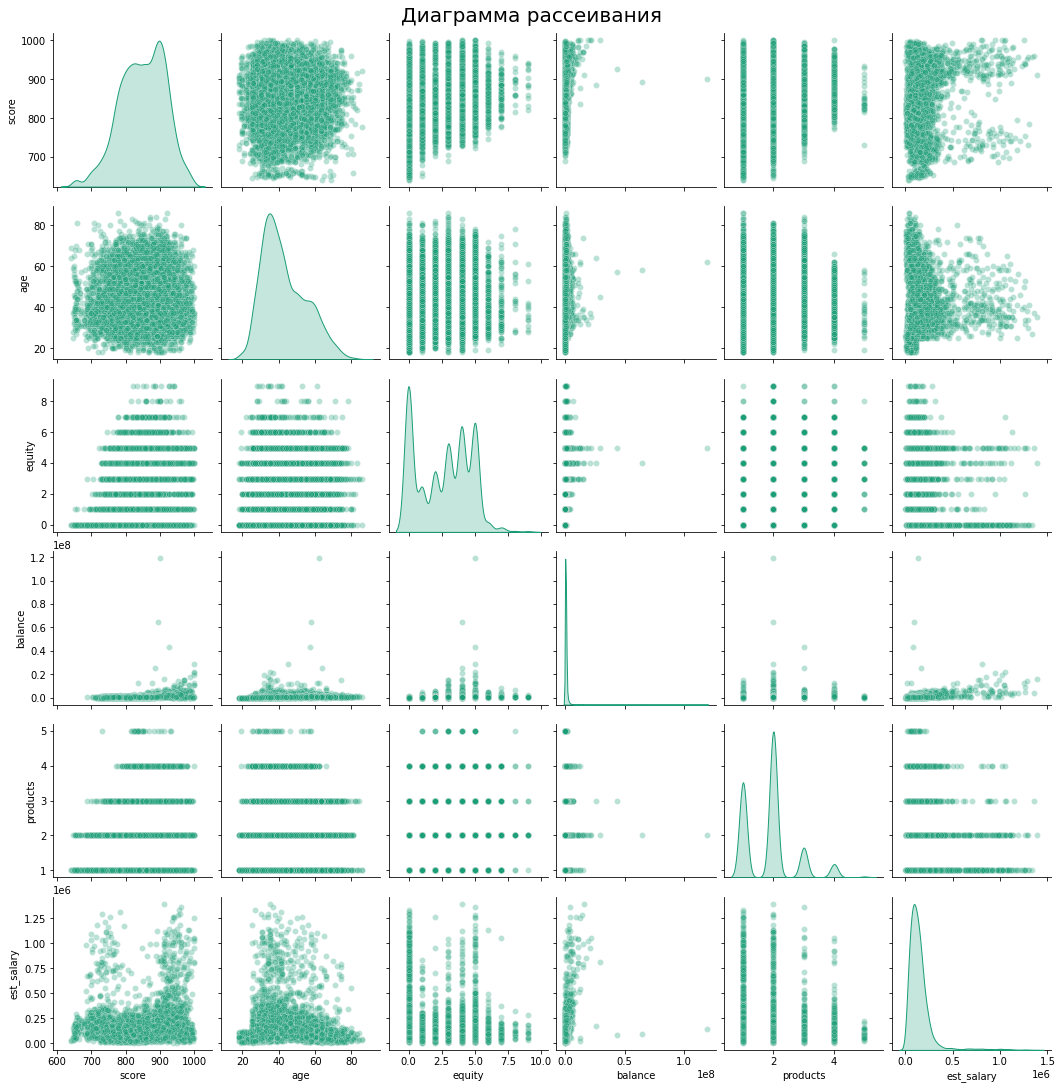

In [47]:
pairplot_cols =['score', 'age', 'equity', 'balance', 'products', 'est_salary']

sns.set_palette("Dark2")
sns.pairplot(data[pairplot_cols], diag_kind = 'kde', plot_kws = {'alpha': 0.3})

plt.suptitle(f'Диаграмма рассеивания', y=1.01, size = 20);

**Комментарии:** Диаграмма рассеивания частично подтверждает выводы по таблице корреляции.
- между скорингом и балансом положительная корреляция при балансе от 300 тыс. и скоринге от 900 баллов, до этого зависимости нет
- между зарплатой и балансом положительная корреляция почти незаметна, также проявляется при больших значениях.
- а вот между стоимостью имущества и количеством открытых продуктов банка на графике связи нет, клиенты с разными оценками имущества имеют могут иметь как 1 открытый продукт, так и все 5.

**Вывод: ярко выраженной зависимости между общими данными датасета не обнаружено**

**Дальше изучим данные в разрезе оттока клиентов по каждому столбцу с целью обнаружить группы клиентов, наиболее подверженные уходу из банка**

### Нормализованные гистограммы по каждому столбцу в разрезе оттока

In [48]:
def normalize_barplot(data, col):
    '''
    Функция для построения нормализованной гистограммы по категориальным колонкам
    в разрезе ушел клиент или остался.
    На вход принимает датасет и его колонку, на выходе гистограмма
    '''
    dict_col = {'city':'город', 
                'gender': 'пол',
                'equity': 'оценка собственности',
                'products': 'количество продуктов', 
                'credit_card': 'наличие кредитной карты', 
                'last_activity': 'последняя активность',
                'credit_history': 'кредитная история', 
                'balance_cat': 'уровень баланса', 
                'est_salary_cat': 'размер зарплаты', 
                'age_cat': 'возраст'}
    
    #определяем название региона на русском по словарю соответствия столбцов и рус.названий
    rus_text="".join(values for key, values in dict_col.items() if key == str(col))
        
    cat = (data.groupby(['churn'])[str(col)]
        .value_counts(normalize=True)
        .mul(100)
        .rename('percent')
        .reset_index()
       )
    
    labels={False: "Действующие", True: "Ушедшие"}
    cat.churn = cat.churn.map(labels)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.title(f'Распределение ушедших и оставшихся клиентов по признаку {rus_text}')

    sns.barplot(data=cat, x=str(col),y='percent',hue='churn', ax=ax)
    plt.ylabel('процент')
    plt.xlabel(rus_text)
    plt.legend(title='Ушли или остались')
    plt.show();

Построю нормализованную гистограмму по каждой колонке, выделю подкатегории клиентов по каждому признаку, которые наиболее склонны к уходу из банка.

#### Отток по городам

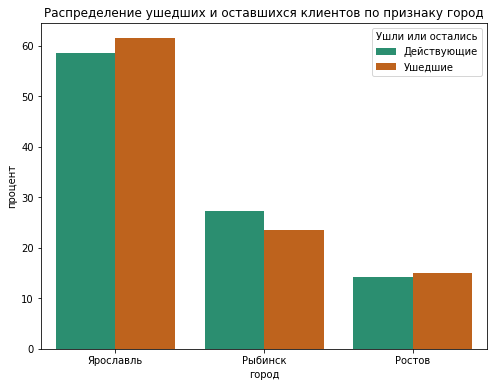

In [49]:
normalize_barplot(data, 'city')

В Ярославле и Ростове клиенты более склонны к уходу из банка, хотя и не на много

#### Отток по полу

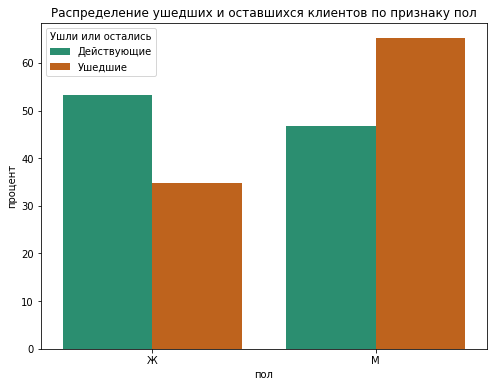

In [50]:
normalize_barplot(data, 'gender')

Мужчины довольно сильно склонны к уходу из банка

#### Отток по оценке собственности

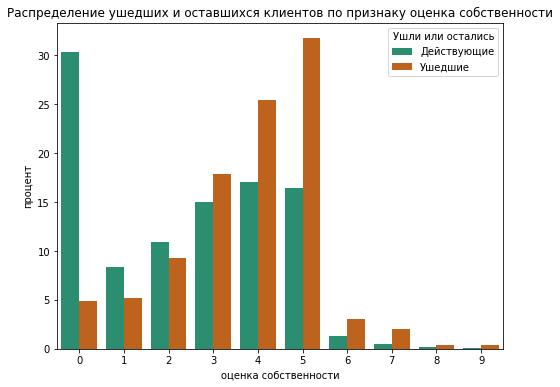

In [51]:
normalize_barplot(data, 'equity')

К уходу из банка склонны клиенты с оценкой собствености от 3 выше, в основном с 4 и 5

#### Отток по количеству продуктов

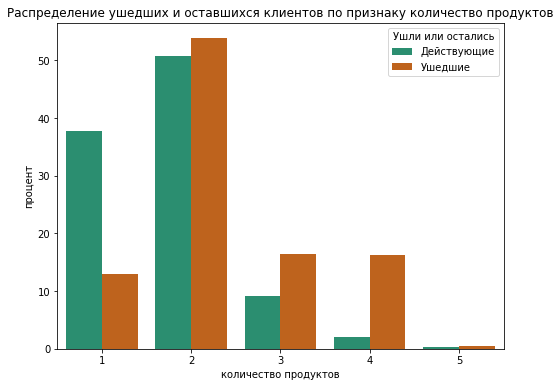

In [52]:
normalize_barplot(data, 'products')

К уходу из банка склонны клиенты с 2-5 продуктами, в основном с 3 и 4

#### Отток по наличию кредитной карты

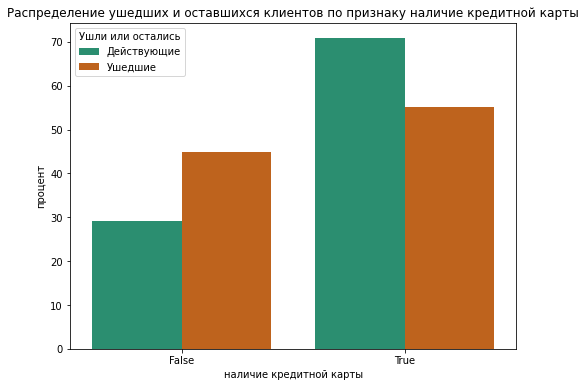

In [53]:
normalize_barplot(data, 'credit_card')

Чаще уходят клиенты, у которых нет кредитной карты

#### Отток по последней активности

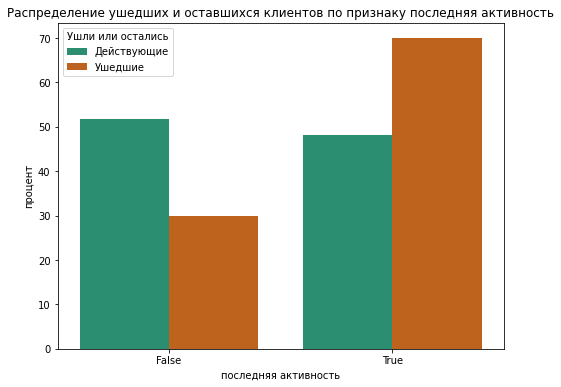

In [54]:
normalize_barplot(data, 'last_activity')

Клиенты, которые были активны в последнее время, уходят чаще

#### Отток по кредитной истории

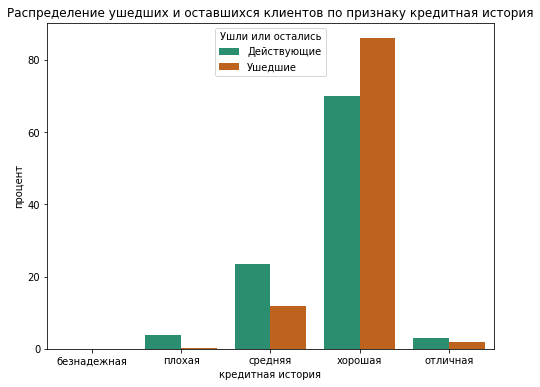

In [55]:
normalize_barplot(data, 'credit_history')

Клиенты с хорошей кредитной историей больше склонны к уходу из банка

#### Отток по уровню баланса

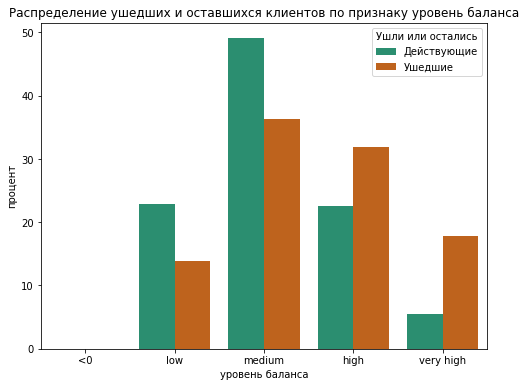

In [56]:
normalize_barplot(data, 'balance_cat')

К уходу из банка склонны клиенты с высоким и очень высоким балансом, % клиентов со средним балансом почти одинаковый для ушедших и оставшихся

#### Отток по размеру зарплаты

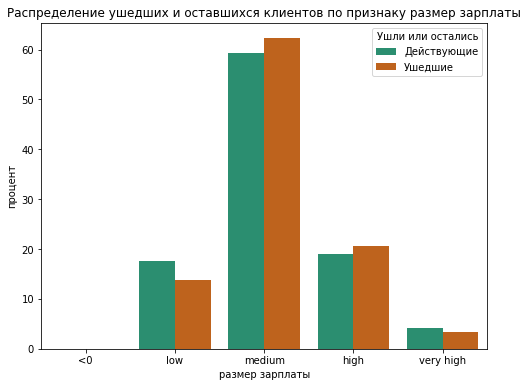

In [57]:
normalize_barplot(data, 'est_salary_cat')

Клиенты со средней зарплатой и высокой более склонны уходить из банка

#### Отток по возрасту

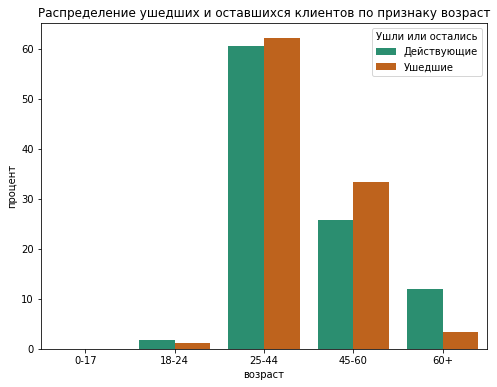

In [58]:
normalize_barplot(data, 'age_cat')

Клиенты от 25 до 60 более склонны уходить из банка, при этом процент ушедших выше в группе 45-60 лет.

#### Вывод
Отток выше в следующих группах клиентов:
- жители Ярославля и Ростова
- мужчины
- возраст 25-60 лет
- оценка собственности от 3
- количество продуктов 2 и более
- без кредитной карты
- активные в последнее время
- с хорошей кредитной историей
- с высоким и очень высоким балансом
- со средней и высокой зарплатой

### Сегментирование
- Гипотезы по выделению сегмента с 2-4 признаками (размеры сегмента примерно 500-2000)
- Выделение сегмента, проверка % оттока в нем и размера сегмента

Таким способом выделю несколько сегментов, составлю портреты пользователей, наиболее часто расторгающих договор с банком

In [59]:
base_churn = round(data.churn.mean()*100,2)
print (f'Процент оттока клиентов в целом по датасету: {base_churn}%')

Процент оттока клиентов в целом по датасету: 17.95%


#### Сегмент 1
Мужчины 25-60 лет без кредитной карты

In [60]:
seg1 = data.query('gender == "М" and age_cat in ["45-60", "25-44"] and credit_card == False')
print (f'Размер сегмента {seg1.shape[0]} клиентов')
print(f'Процент оттока составляет {round(seg1.churn.mean()*100,2)}%')

Размер сегмента 1199 клиентов
Процент оттока составляет 35.03%


#### Сегмент 2
Мужчины из Ярославля с высоким и очень высоким балансом

In [61]:
seg2 = data.query('gender == "М" and city == "Ярославль" and balance_cat in ["high", "very high"]')
print (f'Размер сегмента {seg2.shape[0]} клиентов')
print(f'Процент оттока составляет {round(seg2.churn.mean()*100,2)}%')

Размер сегмента 795 клиентов
Процент оттока составляет 47.8%


#### Сегмент 3
Мужчины с 2 продуктами, хорошей кредитной историей и оценкой собственности от 4 и выше

In [62]:
seg3 = data.query('gender == "М" and products >=2 and credit_history=="хорошая" and equity>=4 ')
print (f'Размер сегмента {seg3.shape[0]} клиентов')
print(f'Процент оттока составляет {round(seg3.churn.mean()*100,2)}%')

Размер сегмента 1364 клиентов
Процент оттока составляет 44.06%


#### Сегмент 4
Мужчины активные в последнее время, без кредитной карты

In [63]:
seg4 = data.query('gender == "М" and last_activity == True and  credit_card == False')
print (f'Размер сегмента {seg4.shape[0]} клиентов')
print(f'Процент оттока составляет {round(seg4.churn.mean()*100,2)}%')

Размер сегмента 705 клиентов
Процент оттока составляет 41.42%


#### Вывод
Выделила 4 сегмента, в которых доля оттока составляет от 35 до почти 48%. Ниже в исследовании подготовлю рекомендации для каждого сегмента

### Выдвижение и проверка 2 статистических гипотез

#### Проверка статистической гипотезы различия дохода между теми клиентами, которые ушли и теми, которые остались
    
```
H_0: Доход ушедших клиентов = Доход действующих клиентов 
H_a: Доход ушедших клиентов ≠ Доход действующих клиентов 
alpha = 0.05
Использую  t-тест Студента
```

In [64]:
alpha = .05 # критический уровень статистической значимости

churn_0 = data[data['churn'] ==False].est_salary
churn_1 = data[data['churn'] ==True].est_salary

# results = вызов метода для проверки гипотезы
results = st.ttest_ind(churn_0,churn_1, equal_var=False)

print('p-значение: ', results.pvalue) # вывод значения p-value на экран

if results.pvalue<alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  0.9039899002279885
Не получилось отвергнуть нулевую гипотезу


Можно заключить, что нет оснований считать, что доход ушедших клиентов не равен доходу действующих клиентов 

#### Проверка статистической гипотезы различия владения кредитной картой между мужчинами и женщинами

```
H_0: Количество кредитных карт мужчин = Количество кредитных карт женщин 
H_a: Количество кредитных карт мужчин ≠ Количество кредитных карт женщин
alpha = 0.05
Использую Z-тест
```

In [65]:
alpha = .05 # критический уровень статистической значимости

#количество клиентов с кредитными картами
successes = np.array([data.query('gender == "М" and credit_card == True').credit_card.count(),
                      data.query('gender == "Ж" and credit_card == True').credit_card.count()])

#общее количество клиентов
trials = np.array([data.query('gender == "М"').credit_card.count(), 
                   data.query('gender == "Ж"').credit_card.count()])

# пропорция успехов в первой и второй группе:
p1 = successes[0]/trials[0]
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)
print('Доля пользователей, совершивших событие в 1 группе: ', round(p1*100, 2))
print('Доля пользователей, совершивших событие во 2 группе: ', round(p2*100, 2))

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.0
Доля пользователей, совершивших событие в 1 группе:  74.02
Доля пользователей, совершивших событие во 2 группе:  62.06
Отвергаем нулевую гипотезу: между долями есть значимая разница


## Выводы по проекту

Цель исследования была:
- Проанализировать клиентов регионального банка и выделить сегменты клиентов, которые склонны уходить из банка.
- Подготовить рекомендации по уменьшению оттока для каждого из выделенных сегментов 

Датасет содержит:
- До обработки 10000
- После обработки 9854
- % удаленных данных 1.46

После проведенного стат.теста нет оснований считать, что доход ушедших клиентов ≠ доходу действующих клиентов, а также имеется достаточно оснований утверждать, что количество кредитных карт мужчин ≠ количеству кредитных карт женщин

Процент оттока клиентов в целом по датасету: 17,95%

Отток выше в следующих группах клиентов:
- жители Ярославля и Ростова
- мужчины
- возраст 25-60 лет
- оценка собственности от 3
- количество продуктов 2 и более
- без кредитной карты
- активные в последнее время
- с хорошей кредитной историей
- с высоким и очень высоким балансом
- со среднейи и высокой зарплатой

<u>Среди них выделили 4 сегмента клиентов:</u>

Все сегменты включают в себя мужчин, поэтому общая рекомендация - выпуск карт с мужским дизайном, повышенный кешбэк на товары мужских категорий.

**Мужчины 25-60 лет без кредитной карты**
- Размер сегмента 1199 клиентов
- Процент оттока составляет 35.03%

Рекомендации: предложить кредитку с хорошими условиями по отсрочке

**Мужчины из Ярославля с высоким и очень высоким балансом**
- Размер сегмента 795 клиентов
- Процент оттока составляет 47.8%

Рекомендации: предложить депозиты или другие способы инвестирования под более выгодный процент, чем конкуренты

**Мужчины с 2 продуктами, хорошей кредитной историей и оценкой собственности от 4 и выше**
- Размер сегмента 1364 клиентов
- Процент оттока составляет 44,06%

Рекомендации: доп.услуги в виде страхования собственности, сниженный процент на кредиты (т.к история хорошая и есть имущество для залога)

**Мужчины активные в последнее время, без кредитной карты**
- Размер сегмента 705 клиентов
- Процент оттока составляет 41.42%

Рекомендации: предложить кредитку с хорошими условиями по отсрочке